## Imports

In [1]:
%%capture
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import itertools
from sklearn.utils import shuffle
%run "./utils.ipynb"
%run "./Data preprocessing.ipynb"

## Load Numpy Array

### Resize array

In [2]:
X.shape

(17615, 100, 100)

In [3]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


In [4]:
X = tf.keras.applications.resnet_v2.preprocess_input(
    X, data_format=None
)

In [5]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 42, stratify=y)

## Model Building

In [6]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201,InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [7]:
model = tf.keras.models.Sequential()
base_model = tf.keras.applications.ResNet50V2(
    include_top=False, weights='imagenet',pooling='max'
)

In [8]:
# base_model.trainable = False
model.add(base_model)
model.add(BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(0.02)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(0.02)))
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(5, activation='softmax'))

train_layers = [layer for layer in base_model.layers[::-1][:5]]

for layer in base_model.layers:
  if layer in train_layers:
    layer.trainable = True

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [10]:
# Using early stopping and reduce lr on plateau to control the performance
cb_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0) 
cb_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, verbose=1, mode='auto', restore_best_weights=True)

cbs = [cb_1 , cb_2 ]

In [11]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=8, callbacks=cbs,verbose=1)

Epoch 1/8
413/413 [==============================] - 585s 1s/step - loss: 120.9202 - accuracy: 0.5981 - val_loss: 34.4378 - val_accuracy: 0.8465
Epoch 2/8
413/413 [==============================] - 578s 1s/step - loss: 22.5366 - accuracy: 0.8685 - val_loss: 8.4189 - val_accuracy: 0.9099
Epoch 3/8
413/413 [==============================] - 545s 1s/step - loss: 7.2388 - accuracy: 0.9075 - val_loss: 4.6195 - val_accuracy: 0.9287
Epoch 4/8
413/413 [==============================] - 527s 1s/step - loss: 3.9460 - accuracy: 0.9413 - val_loss: 2.6104 - val_accuracy: 0.9351
Epoch 5/8
413/413 [==============================] - 526s 1s/step - loss: 2.0166 - accuracy: 0.9564 - val_loss: 1.2404 - val_accuracy: 0.9539
Epoch 6/8
413/413 [==============================] - 526s 1s/step - loss:

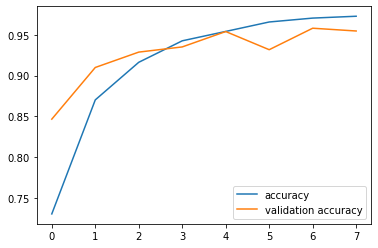

In [12]:
accuracy_graph(history)

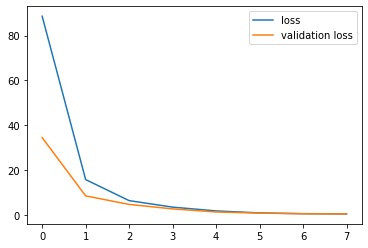

In [13]:
loss_graph(history)

In [14]:
predictions = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, predictions)


Confusion matrix, without normalization
[[868   0   1  23  12]
 [  0 801  73   0   1]
 [  0  45 830   0   0]
 [  5   1   0 869   0]
 [ 21   0   1  17 836]]


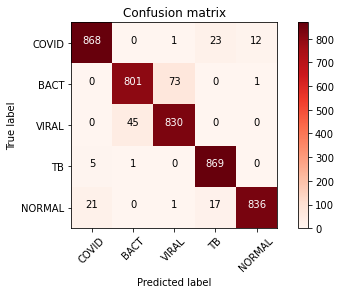

In [15]:
plot_confusion_matrix(cm, ["COVID" ,"BACT", "VIRAL", "TB", "NORMAL"])

In [16]:
print(classification_report(y_test, predictions));

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       904
           1       0.95      0.92      0.93       875
           2       0.92      0.95      0.93       875
           3       0.96      0.99      0.97       875
           4       0.98      0.96      0.97       875

    accuracy                           0.95      4404
   macro avg       0.95      0.95      0.95      4404
weighted avg       0.95      0.95      0.95      4404



In [19]:
import json

with open('./histories/ResNet50V2.json', 'w') as fp:
    json.dump(str(history.history), fp)

In [22]:
tf.keras.models.save_model(
    model, filepath='../models/ResNet50V', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

In [23]:
loaded_model = tf.keras.models.load_model('../models/ResNet50V')

In [25]:

loaded_model.evaluate(X_test, y_test)

138/138 [==============================] - 45s 329ms/step - loss: 0.3933 - accuracy: 0.9546


[0.3932623267173767, 0.9545867443084717]